In [12]:
import numpy as np
import mxnet as mx
import pandas as pd
from datetime import datetime
from IPython import display
from collections import Counter
from matplotlib import pyplot as plt
from mxnet import autograd, nd, init as ginit
from scipy.stats import pearsonr, kendalltau, spearmanr, pointbiserialr
from mxnet.gluon import nn, Block, loss as gloss, data as gdata, Trainer as gTrainer
pd.set_option('display.max_columns', 999)
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()

In [4]:
ziroom_rooms = pd.read_csv('ziroom_rental_dataset.csv')

In [5]:
ziroom_rooms

,is_first_signed,tag_拿铁4.0,tag_独立阳台,tag_智能锁,tag_离地铁近,id,has_video,has_3d,turn,sort_score,bedroom,floor_total,sale_price,bizcircle_和平里,parlor,air_quality,face_南,sale_status_3,area_order,floor,floor_ratio,to_station,have_lift,price,build_year,build_type_塔楼,heating_type_集体供暖,total_houses,green_ratio,config_椅子,config_书架,config_桌子,bed_width,config_床垫,wardrobe,config_空调,bed_counter,sofa_size,activity_信用免押,activity_海燕计划,activity_惠蕾计划,tag_布丁4.0,bizcircle_安定门,face_西,build_type_板楼,config_路由器,tag_深呼吸1.0,config_智能锁,face_东,tag_木棉4.0,face_北,tag_米苏4.0,bizcircle_北新桥,bizcircle_东直门,sale_status_1,sale_status_0,build_type_塔板结合,bizcircle_安贞,config_电视,build_type_未知,config_茶几,tag_绿化率高,heating_type_独立供暖,bizcircle_崇文门,heating_type_壁挂炉,bizcircle_东单,config_电暖气,bizcircle_东四,bizcircle_朝阳门,bizcircle_金宝街,bizcircle_地安门,tag_米苏3.0,tag_布丁3.0,bizcircle_东花市,bizcircle_灯市口,bizcircle_广渠门,heating_type_中央供暖,tag_独立卫生间,tag_木棉3.0,tag_原味4.0,config_电视柜,config_空调扇,bizcircle_建国门内,bizcircle_天坛,bizcircle_永定门,bizcircle_西罗园,bizcircle_交道口,tag_布丁6.0,bizcircle_广安门,bizcircle_白纸坊,config_鞋柜,bizcircle_西直门,bizcircle_车公庄,bizcircle_阜成门,config_书柜,config_油烟机,config_洗衣机,config_电磁炉,config_热水器,config_微波炉,config_冰箱,bizcircle_西单,tag_4.0,bizcircle_德胜门,bizcircle_木樨园,bizcircle_官园,bizcircle_金融街,bizcircle_宣武门,bizcircle_月坛,bizcircle_六铺炕,bizcircle_马甸(海淀区),bizcircle_马连道,bizcircle_木樨地,bizcircle_牛街,tag_米苏6.0,bizcircle_甘家口,tag_优格,tag_优格4.0,bizcircle_天宁寺,bizcircle_陶然亭,tag_拿铁3.0,bizcircle_新街口,bizcircle_西四,config_床头柜,bizcircle_右安门内,bizcircle_长椿街,tag_拿铁6.0,bizcircle_五道口,bizcircle_南沙滩,bizcircle_亚运村,bizcircle_奥林匹克公园,tag_深呼吸2.0,tag_智能空净,config_智能窗帘,bizcircle_北工大,bizcircle_劲松,bizcircle_华威桥,bizcircle_北苑,bizcircle_百子湾,bizcircle_CBD,bizcircle_朝青,bizcircle_定福庄,bizcircle_成寿寺,bizcircle_常营,bizcircle_管庄,bizcircle_朝阳公园,bizcircle_酒仙桥,bizcircle_四惠,bizcircle_石佛营,bizcircle_甘露园,bizcircle_工体,bizcircle_建国门外,bizcircle_东大桥,bizcircle_呼家楼,bizcircle_豆各庄,bizcircle_大山子,bizcircle_双井,bizcircle_大望路,tag_燕窝4.0,bizcircle_垡头,bizcircle_欢乐谷,bizcircle_高碑店,tag_木棉6.0,config_浴霸,tag_清语,tag_清语4.0,heating_type_无供暖,bizcircle_双桥,bizcircle_国展,bizcircle_燕莎,bizcircle_团结湖,bizcircle_三元桥,config_壁挂炉,bizcircle_红庙,bizcircle_十里河,bizcircle_惠新西街,bizcircle_亚运村小营,bizcircle_芍药居,bizcircle_健翔桥,config_机顶盒,bizcircle_潘家园,bizcircle_农展馆,bizcircle_十里堡,bizcircle_甜水园,bizcircle_太阳宫,bizcircle_西坝河,config_热水壶,config_台式燃气灶,bizcircle_白石桥,bizcircle_北太平庄,bizcircle_厂洼,bizcircle_紫竹桥,bizcircle_定慧寺,bizcircle_中关村,bizcircle_五棵松,bizcircle_二里庄,bizcircle_公主坟,bizcircle_海淀北部新区,bizcircle_西北旺,bizcircle_海淀其它,bizcircle_军博,bizcircle_牡丹园,bizcircle_马连洼,bizcircle_门头沟其它,bizcircle_上地,bizcircle_清河,bizcircle_四季青,bizcircle_西山,bizcircle_双榆树,tag_拿铁2.0,bizcircle_苏州桥,bizcircle_田村,bizcircle_海淀玉泉路,bizcircle_魏公村,bizcircle_万寿路,config_嵌入式燃气灶,bizcircle_学院路,bizcircle_回龙观,bizcircle_西三旗,activity_限时优惠,bizcircle_圆明园,bizcircle_玉泉路,bizcircle_杨庄,bizcircle_知春路,bizcircle_北京南站,bizcircle_洋桥,bizcircle_右安门外,bizcircle_菜户营,tag_布丁5.0,tag_共享客厅,bizcircle_五里店,bizcircle_马家堡,bizcircle_草桥,bizcircle_玉泉营,bizcircle_方庄,bizcircle_大红门,bizcircle_科技园区,bizcircle_花乡,bizcircle_和义,bizcircle_赵公口,bizcircle_角门,bizcircle_卢沟桥,bizcircle_刘家窑,bizcircle_蒲黄榆,bizcircle_青塔,bizcircle_宋家庄,tag_智能新风,bizcircle_西红门,bizcircle_八角,bizcircle_古城,bizcircle_鲁谷,bizcircle_老山,bizcircle_苹果园,bizcircle_石景山玉泉路
0,0,1.0,1.0,1.0,1.0,629502227,0,0,0,8.248,3,16,103977,1.0,1,0,1.0,1.0,15.00,1,0.062500,402,1,8.196988,24.0,1.0,1.0,11.0,30.0,2.0,1.0,2.0,1.5,1.0,2.0,1.0,1.5,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [7]:
def pre_process(dataset, label='price'):
    m, n = dataset.shape
    split_inx = int(m * 0.8)
    dataset = dataset.sample(frac=1).reset_index(drop=True)
    train_set = dataset[:split_inx]
    test_set = dataset[split_inx:]
    del dataset['id']
    dataset = dataset.astype('float32')
    num_index = dataset.index
    train_y = nd.array(dataset['price'][:split_inx], ctx=ctx)
    test_y = nd.array(dataset['price'][split_inx:], ctx=ctx)
    del dataset['price']
    dataset = dataset.apply(lambda x: (x - x.mean()) / x.std())
    train_X = nd.array(dataset[:split_inx], ctx=ctx)
    test_X = nd.array(dataset[split_inx:], ctx=ctx)
    return train_set, test_set, train_X, train_y, test_X, test_y

In [8]:
train_ziroom_set, test_ziroom_set, train_X, train_y, test_X, test_y = pre_process(ziroom_rooms)

In [10]:
train_X


[[-0.568894   -0.62248653 -0.6494467  ... -0.0580734  -0.06514154
  -0.016976  ]
 [-0.568894   -0.62248653  1.5396241  ... -0.0580734  -0.06514154
  -0.016976  ]
 [-0.568894   -0.62248653 -0.6494467  ... -0.0580734  -0.06514154
  -0.016976  ]
 ...
 [-0.568894    1.6063063   1.5396241  ... -0.0580734  -0.06514154
  -0.016976  ]
 [-0.568894   -0.62248653 -0.6494467  ... -0.0580734  -0.06514154
  -0.016976  ]
 [-0.568894    1.6063063  -0.6494467  ... -0.0580734  -0.06514154
  -0.016976  ]]
<NDArray 8329x252 @gpu(0)>

In [13]:
# 定义模型 和 损失函数
loss = gloss.L2Loss()

class NetWithDropout(Block):
    """
    64 * dopout(0.2) * 1
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden_1 = nn.Dense(128, activation='relu')
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Dense(1)

    def forward(self, x):
        y = self.hidden_1(x)
        if autograd.is_training():
            y = self.dropout(y)
        y = self.out(y)
        return y

net = NetWithDropout()
net.initialize(ginit.Normal(sigma=0.01), ctx=ctx)

In [14]:
# 定义损失函数
def rmse(net, features, labels):
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds, labels).mean())
    rmse = rmse.asscalar()
    if np.isnan(rmse):
        raise Exception("get loss of NaN")
    return rmse

In [41]:
# 定义训练过程
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, 
          learning_rate, weight_decay, batch_size):
    """
    使用了Adam优化算法
    """
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    trainer = gTrainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            y = y.as_in_context(ctx)  # 为什么y会变成cpu
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_loss = rmse(net, train_features, train_labels)
        train_ls.append(train_loss)
        epoch += 1
        if epoch % 50 == 0:
#             learning_rate = learning_rate * 0.8  # 衰减
            print("Epoch {}: Train loss: {}".format(epoch, train_loss), end='')
        if test_labels is not None:
            test_loss = rmse(net, test_features, test_labels)
            test_ls.append(test_loss)
            if epoch and epoch % 50 == 0:
                print("; Test Loss: {}".format(test_loss), end='')
        if epoch % 50 == 0:
            print('')
    return train_ls, test_ls

In [43]:
net.initialize(ginit.Normal(sigma=0.01), force_reinit=True, ctx=ctx)
print(net)
print(net.collect_params())
k, num_epochs, learning_rate, weight_decay, batch_size = 5, 450, 0.0003, 0.00125, 20
train_loss, test_loss = train(net, train_X, train_y, None, None, num_epochs, learning_rate, weight_decay, batch_size)
print(np.mean(train_loss[-10:]))

NetWithDropout(
  (hidden_1): Dense(252 -> 128, Activation(relu))
  (dropout): Dropout(p = 0.2, axes=())
  (out): Dense(128 -> 1, linear)
)
netwithdropout0_ (
  Parameter dense0_weight (shape=(128, 252), dtype=float32)
  Parameter dense0_bias (shape=(128,), dtype=float32)
  Parameter dense1_weight (shape=(1, 128), dtype=float32)
  Parameter dense1_bias (shape=(1,), dtype=float32)
)
Epoch 50: Train loss: 0.22154103219509125
Epoch 100: Train loss: 0.20292878150939941
Epoch 150: Train loss: 0.18061189353466034
Epoch 200: Train loss: 0.17236328125
Epoch 250: Train loss: 0.16119058430194855
Epoch 300: Train loss: 0.14346428215503693
Epoch 350: Train loss: 0.1273539662361145
Epoch 400: Train loss: 0.1226436048746109
Epoch 450: Train loss: 0.12430452555418015
0.124840006


In [52]:
def set_figsize(figsize=(3.5, 2.5)):
    """Change the default figure size"""
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize
    

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    """
    对数 plot: 10^1, 10^-1, 10^-2
    """
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

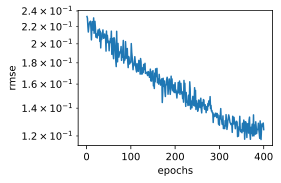

In [53]:
semilogy(range(1, num_epochs - 50 + 1), train_loss[50:], 'epochs', 'rmse')

In [55]:
def train_and_pred(lr, wd, num_epochs):
    net.initialize(ginit.Normal(sigma=0.01), force_reinit=True, ctx=ctx)
    print(net)
    train_ls, _ = train(net, train_X, train_y, None, None, num_epochs, lr, wd, batch_size)
    print("Trainning history: ", train_ls[-10:])
    semilogy(range(1, num_epochs - 50 + 1), train_ls[50:], 'epochs', 'rmse')
    return generate_submission(net, test_X)
    
def generate_submission(net, test_x):
    preds = np.exp(net(test_x).asnumpy())
#     test_data['RentalPrice'] = pd.Series(preds.reshape(1, -1)[0])
#     submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
#     submission.to_csv('submission_log.csv', index=False)
    return preds

NetWithDropout(
  (hidden_1): Dense(252 -> 128, Activation(relu))
  (dropout): Dropout(p = 0.2, axes=())
  (out): Dense(128 -> 1, linear)
)
Epoch 50: Train loss: 0.22207602858543396
Epoch 100: Train loss: 0.1896980255842209
Epoch 150: Train loss: 0.17547616362571716
Epoch 200: Train loss: 0.16310149431228638
Epoch 250: Train loss: 0.16145551204681396
Epoch 300: Train loss: 0.13758738338947296
Epoch 350: Train loss: 0.13586533069610596
Epoch 400: Train loss: 0.12806867063045502
Epoch 450: Train loss: 0.11794920265674591
Epoch 500: Train loss: 0.11971919238567352
Trainning history:  [0.12228488, 0.117185935, 0.11918553, 0.12293217, 0.116105914, 0.11678715, 0.11489433, 0.12157608, 0.12496982, 0.11971919]


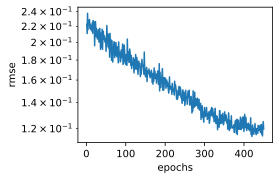

In [58]:
test_proditions = train_and_pred(learning_rate, weight_decay, 500)

In [59]:
np.abs(test_proditions.reshape((test_proditions.shape[0], )) - nd.exp(test_y).asnumpy()).mean(axis=0)

519.6308

In [60]:
test_proditions

array([[4079.4556],
       [5455.3027],
       [4105.824 ],
       ...,
       [2860.9023],
       [4292.4893],
       [3208.6438]], dtype=float32)